<a href="https://colab.research.google.com/github/sal0m/HSE_ML_hw3/blob/main/Hometasks/Pro/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [7]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sns.set(rc={"axes.labelsize": 10})  # Отключает предупреждения о distplot

%matplotlib inline

In [5]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [8]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm

INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:01<00:00, 320.42it/s]


In [5]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.47002%
Missing data in test: 4.33051%


In [6]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [7]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:23<00:00, 18.61it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 653.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 270.4 MB


(None, None)

ниже код для бейзлайна с катбустом

удаляем уникальные идентификаторы

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

In [ ]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

In [ ]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 2.52s	remaining: 5.03s
1:	learn: 0.1356356	total: 4.93s	remaining: 2.47s
2:	learn: 0.1178118	total: 8.42s	remaining: 0us


In [ ]:
predictions = cb.predict_proba(df_test.fillna(''))

In [ ]:
predictions

array([[0.99163532, 0.00836468],
       [0.93590912, 0.06409088],
       [0.91453061, 0.08546939],
       ...,
       [0.97087772, 0.02912228],
       [0.97087772, 0.02912228],
       [0.97087772, 0.02912228]])

In [ ]:
predictions[:, 1]

array([0.02128583, 0.0642762 , 0.05313567, ..., 0.0293629 , 0.0293629 ,
       0.0293629 ])

увидела, что рок аук меньше 0.5, следовательно, перепутаны классы, следовательно, меняем predictions[:, 0] на predictions[:, 1]

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
sub.head()

,TransactionID,isFraud
0,3404559,0.008365
1,3404560,0.064091
2,3404561,0.085469
3,3404562,0.008365
4,3404563,0.029122


In [ ]:
# Сохранение submission
sub.to_csv('submission_baseline_3.csv', index=False)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [8]:
y_train = df_train['isFraud'].astype("uint8").copy()

In [9]:
y_train.value_counts() #очевидный дисбаланс классов

,count
isFraud,
0,402838
1,14721


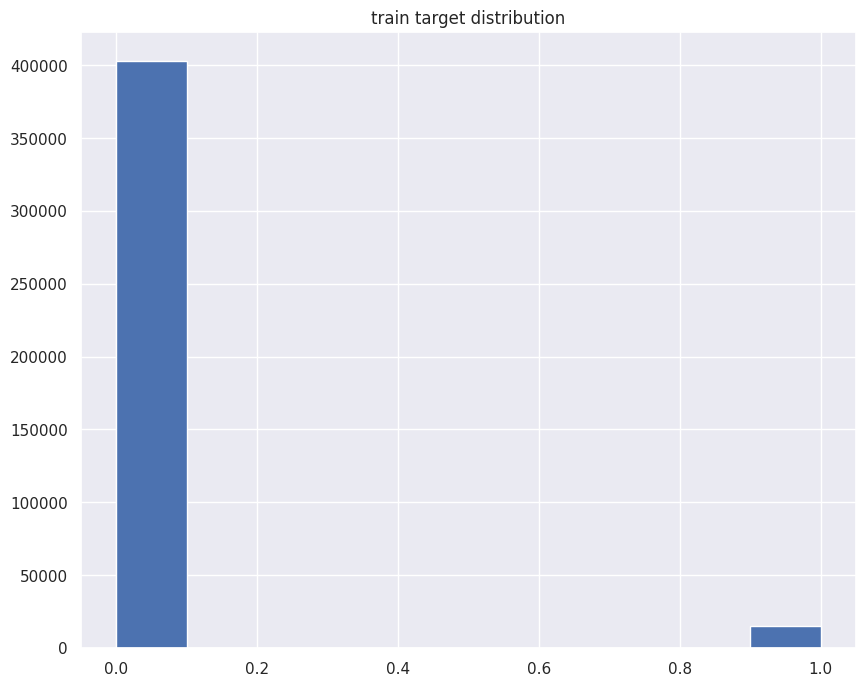

In [10]:
plt.figure(figsize=(10, 8))
plt.title('train target distribution')
plt.hist(y_train)
plt.show()

Можно заметить, что данные содержат признак, отвечающий за момент времени совершения транзакции - 'TransactionDT'. Изучим его подробнее.

In [11]:
df_train['TransactionDT'].min(), df_test['TransactionDT'].max(), df_test['TransactionDT'].max() - df_train['TransactionDT'].min()

(86400, 15811131, 15724731)

и по графику сразу видим, что из теста половину данных убрали)))

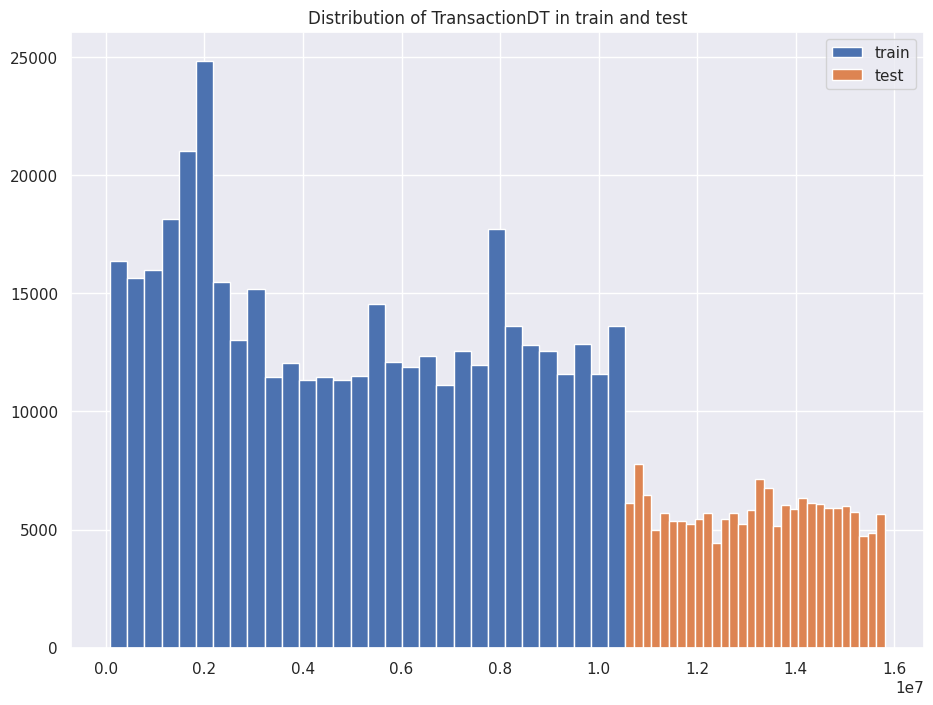

In [12]:
plt.figure(figsize=(11, 8))
plt.title('Distribution of TransactionDT in train and test')
plt.hist(df_train['TransactionDT'], label='train', bins=30)
plt.hist(df_test['TransactionDT'], label='test', bins=30)
plt.legend(loc='best')
plt.show()

Можно предположить, что время для этого признака измеряется в секундах, тогда похоже на то, что данные из трейна и теста - это данные за полгода.

In [13]:
(df_test['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

181.99920138888888

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 653.1 MB


In [ ]:
df_train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,4.175590e+05,417559.000000,4.175590e+05,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,...,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000
mean,3.195779e+06,0.035255,4.976936e+06,134.666550,9865.320371,359.317413,153.241013,198.968597,268.443817,77.828590,...,121.845230,9.424510,164.045456,176.410309,101.581215,9.066201,10.024220,101.160324,99.469414,3.111026
std,1.205390e+05,0.184424,3.099220e+06,238.153122,4900.674210,160.263565,11.823440,41.500313,113.603432,24.975363,...,41.686813,1.483503,131.206863,152.378143,32.748356,0.951318,0.328851,24.053787,5.763682,9.910035
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,99.000000,99.000000,99.000000,99.000000,9.000000,...,99.000000,9.000000,99.000000,99.000000,99.000000,9.000000,10.000000,99.000000,99.000000,-1.000000
25%,3.091390e+06,0.000000,2.072820e+06,42.950001,6019.000000,204.000000,150.000000,166.000000,184.000000,87.000000,...,99.000000,9.000000,99.000000,99.000000,99.000000,9.000000,10.000000,99.000000,99.000000,-1.000000
50%,3.195779e+06,0.000000,4.822648e+06,68.949997,9633.000000,360.000000,150.000000,226.000000,269.000000,87.000000,...,99.000000,9.000000,99.000000,99.000000,99.000000,9.000000,10.000000,99.000000,99.000000,-1.000000
75%,3.300168e+06,0.000000,7.786364e+06,125.000000,14128.000000,512.000000,150.000000,226.000000,327.000000,87.000000,...,166.000000,9.000000,100.000000,127.000000,99.000000,9.000000,10.000000,99.000000,99.000000,-1.000000
max,3.404558e+06,1.000000,1.054080e+07,31937.390625,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


Посмотрим на распределение значений числового признака 'TransactionAmt' в обучающей выборке:

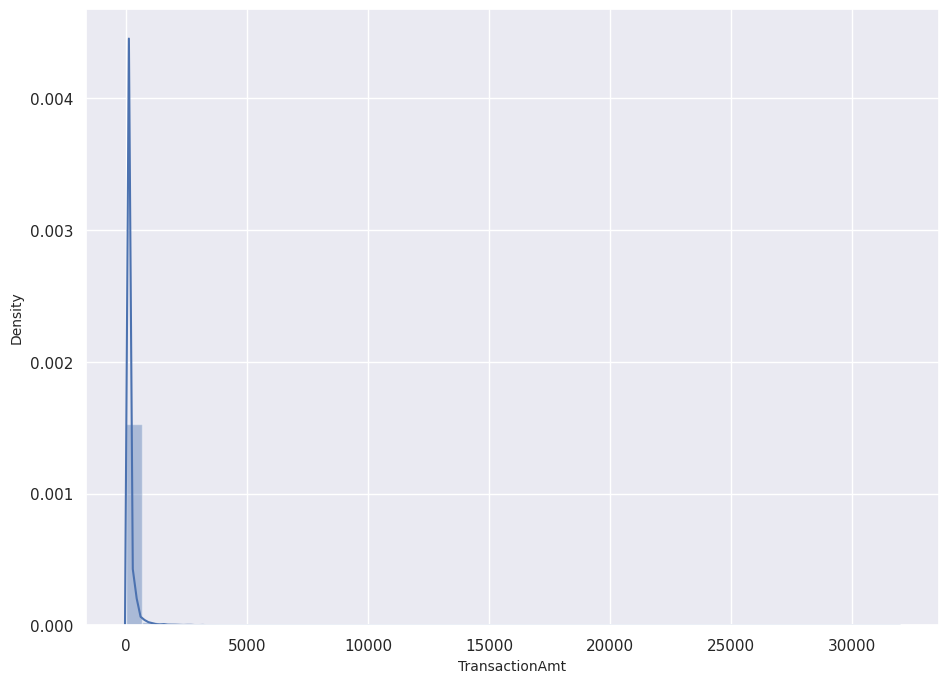

In [23]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt'])
plt.show()

Как видно, распределение очень сильно смещено. Прологарифмируем признак и добавим результат в данные как новый:

In [9]:
df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])

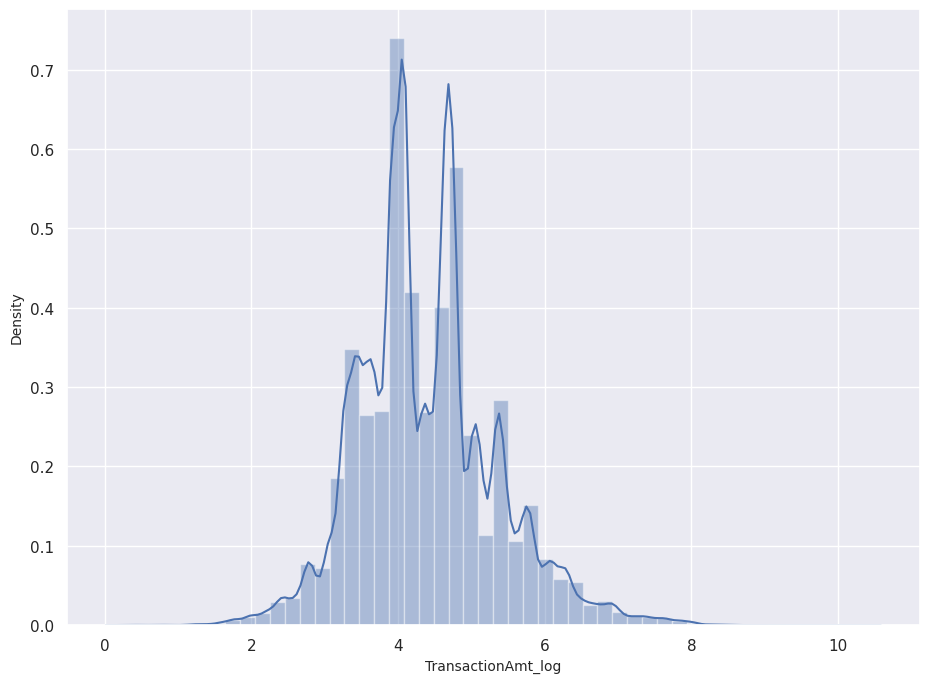

In [24]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt_log'])
plt.show()

In [19]:
df_train['TransactionAmt'].value_counts()[:15]

,count
TransactionAmt,
59.000000,20509
117.000000,19544
100.000000,16685
107.949997,15869
57.950001,15615
50.000000,14270
49.000000,10725
226.000000,7966
39.000000,7490


Это означает, что можно рассмотреть признак "количество центов" (вдруг мошенничество чаще совершается в случае "нецелых" транзакций?). Добавим его в данные и построим два его распределения: для мошеннических и обычных транзакций.

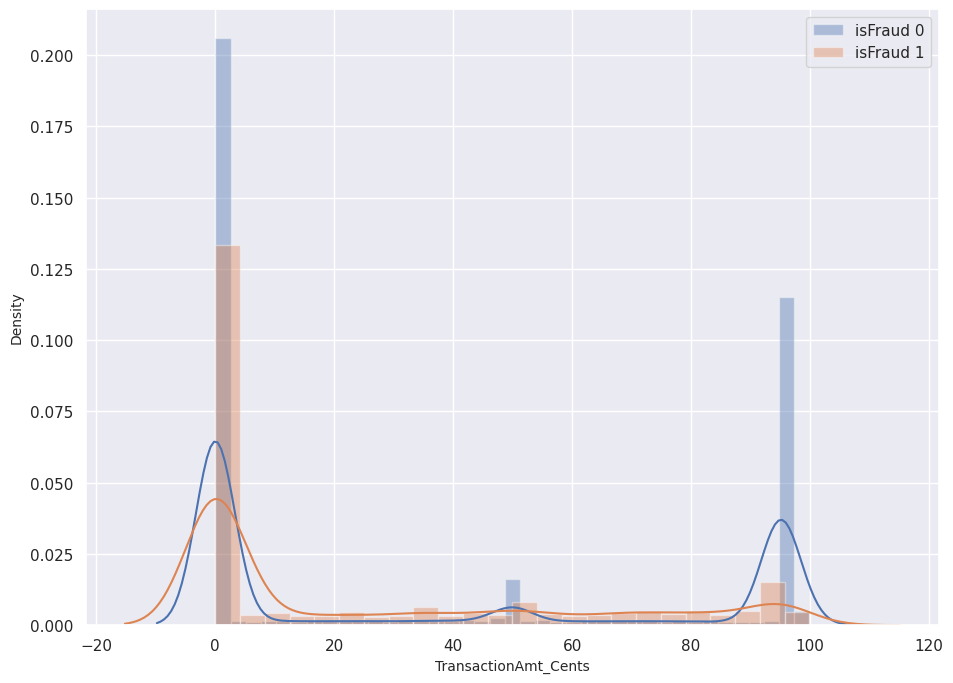

In [10]:
df_train['TransactionAmt_Cents'] = np.modf(df_train['TransactionAmt'])[0] * 100
df_test['TransactionAmt_Cents'] = np.modf(df_test['TransactionAmt'])[0] * 100

plt.figure(figsize=(11, 8))
sns.distplot(df_train[df_train['isFraud'] == 0]['TransactionAmt_Cents'], label='isFraud 0')
sns.distplot(df_train[df_train['isFraud'] == 1]['TransactionAmt_Cents'], label='isFraud 1')
plt.legend(loc='best')
plt.show()

видим, что пики в распределении у нормальных и мошеннических транзакций схожи

Из имеющихся признаков можно извлекать новые. Многие признаки анонимизированы, однако есть достаточно понятные - скажем, почта или OS устройства, с которого совершалась транзакция. Извлечем новый признак - окончание почты, который может нести в себе какую-нибудь информацию - например, информацию о стране (если название домена заканчивается на `.fr`).

In [11]:
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])

df_train[['P_emaildomain', 'P_emaildomain_suffix', 'R_emaildomain', 'R_emaildomain_suffix']].tail(10)

,P_emaildomain,P_emaildomain_suffix,R_emaildomain,R_emaildomain_suffix
417549,gmail.com,com,NaN,nan
417550,gmail.com,com,NaN,nan
417551,att.net,net,NaN,nan
417552,anonymous.com,com,NaN,nan
417553,yahoo.com,com,NaN,nan
417554,gmail.com,com,NaN,nan
417555,gmail.com,com,NaN,nan
417556,hotmail.com,com,hotmail.com,com
417557,gmail.com,com,NaN,nan
417558,gmail.com,com,NaN,nan


Новые признаки можно извлекать на основании сочетаний некоторых имеющихся. Например, добавим в данные признак, отвечающий за то, совпадают ли домены покупателя и получателя - вдруг это что-то даст.

In [12]:
df_train['same_emaildomain'] = (df_train['P_emaildomain'].astype(str) == df_train['R_emaildomain'].astype(str)).astype('uint8')
df_test['same_emaildomain'] = (df_test['P_emaildomain'].astype(str) == df_test['R_emaildomain'].astype(str)).astype('uint8')
df_train[['P_emaildomain', 'R_emaildomain', 'same_emaildomain']].tail()

,P_emaildomain,R_emaildomain,same_emaildomain
417554,gmail.com,NaN,0
417555,gmail.com,NaN,0
417556,hotmail.com,hotmail.com,1
417557,gmail.com,NaN,0
417558,gmail.com,NaN,0


скомбинируем признаки 'card3' и 'card5' - они входят в топ-50 важных признаков для модели из бейзлайна.

In [13]:
df_train['card3_card5'] = df_train['card3'].astype(str) + '_' + df_train['card5'].astype(str)
df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)
df_train[['card3', 'card5', 'card3_card5']].head(10)

,card3,card5,card3_card5
0,150.0,142.0,150.0_142.0
1,150.0,102.0,150.0_102.0
2,150.0,166.0,150.0_166.0
3,150.0,117.0,150.0_117.0
4,150.0,102.0,150.0_102.0
5,150.0,226.0,150.0_226.0
6,150.0,166.0,150.0_166.0
7,150.0,226.0,150.0_226.0
8,150.0,226.0,150.0_226.0
9,150.0,224.0,150.0_224.0


In [14]:
for col in ['card3', 'card5', 'card3_card5']:
    print('Number of categories in train for {}: {}'.format(col, df_train[col].nunique()))

Number of categories in train for card3: 106
Number of categories in train for card5: 111
Number of categories in train for card3_card5: 553


Можно также закодировать категориальные признаки, исходя из их частоты встречаемости в выборке.

In [15]:
for col in ['card1', 'card2']:
    card_freq = df_train[col].value_counts().to_dict()
    df_train['{}_cnt'.format(col)] = df_train[col].map(card_freq)
    df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)
df_train[['card1', 'card1_cnt', 'card2', 'card2_cnt']].head(10)

,card1,card1_cnt,card2,card2_cnt
0,13926,29,99.0,6563
1,2755,526,404.0,2371
2,4663,778,490.0,26366
3,18132,2970,567.0,4329
4,4497,9,514.0,10587
5,5937,6,555.0,29919
6,12308,163,360.0,10518
7,12695,4837,490.0,26366
8,2803,4291,100.0,5372
9,17399,1293,111.0,31710


наряду с 'card1' и 'card2', одним из важнейших признаков для модели в бейзлайне является 'TransactionAmt'. Давайте добавим в данные признаки, отвечающие за среднюю, медианную, максимальную и минимальную суммы покупок для каждой категории в 'card1' и 'card2'.

In [16]:
new_cols = []
for col in ['card1', 'card2']:
    for agg_type in ['mean', 'median', 'min', 'max']:
        agg_col_name = 'TransactionAmt_{}_{}'.format(col, agg_type)
        card_agg = df_train.groupby(col)['TransactionAmt'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(card_agg, how='left', on=col)
        df_test = df_test.merge(card_agg, how='left', on=col)
        new_cols.append(agg_col_name)
df_train[['TransactionAmt', 'card1'] + new_cols[:4] + ['card2'] + new_cols[4:]].head(10)

,TransactionAmt,card1,TransactionAmt_card1_mean,TransactionAmt_card1_median,TransactionAmt_card1_min,TransactionAmt_card1_max,card2,TransactionAmt_card2_mean,TransactionAmt_card2_median,TransactionAmt_card2_min,TransactionAmt_card2_max
0,68.5,13926,368.656219,150.000000,40.00,1343.140015,99.0,177.598236,78.500000,5.000,3069.250000
1,29.0,2755,243.561661,108.949997,10.00,6085.229980,404.0,229.298630,108.949997,5.000,6085.229980
2,59.0,4663,96.343185,59.000000,12.50,994.000000,490.0,132.193436,77.000000,0.424,6450.970215
3,50.0,18132,122.751434,67.949997,6.00,3190.000000,567.0,131.370300,77.949997,6.000,3190.000000
4,50.0,4497,105.083336,108.949997,30.00,200.000000,514.0,217.431381,102.000000,5.000,31937.390625
5,49.0,5937,148.250000,144.000000,49.00,317.500000,555.0,125.474602,68.094002,0.272,3594.949951
6,159.0,12308,107.105888,59.000000,12.50,2161.000000,360.0,98.937828,58.950001,5.000,3472.949951
7,422.5,12695,143.267792,85.000000,7.97,3162.949951,490.0,132.193436,77.000000,0.424,6450.970215
8,15.0,2803,145.065323,77.000000,5.00,3511.949951,100.0,172.210480,92.000000,5.000,5543.229980
9,117.0,17399,127.806297,67.949997,10.95,2775.000000,111.0,148.041199,87.949997,3.500,4301.950195


In [17]:
df_train.drop('TransactionAmt', axis=1, inplace=True)
df_test.drop('TransactionAmt', axis=1, inplace=True)

In [18]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')

        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

100%|██████████| 448/448 [00:26<00:00, 16.73it/s]


In [19]:
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

In [64]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval)

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.027264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34343
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 444
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[561]	valid_0's auc: 0.903529
[LightGBM] [Warning] Categorical features with more bins than the configured max

In [65]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,ProductCD,35,35,34,25
1,card1,566,607,321,145
2,card2,364,333,190,103
3,card3,9,8,8,7
4,card4,15,14,2,2


In [66]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,ProductCD,35,35,34,25,32.25
1,card1,566,607,321,145,409.75
2,card2,364,333,190,103,247.50
3,card3,9,8,8,7,8.00
4,card4,15,14,2,2,8.25


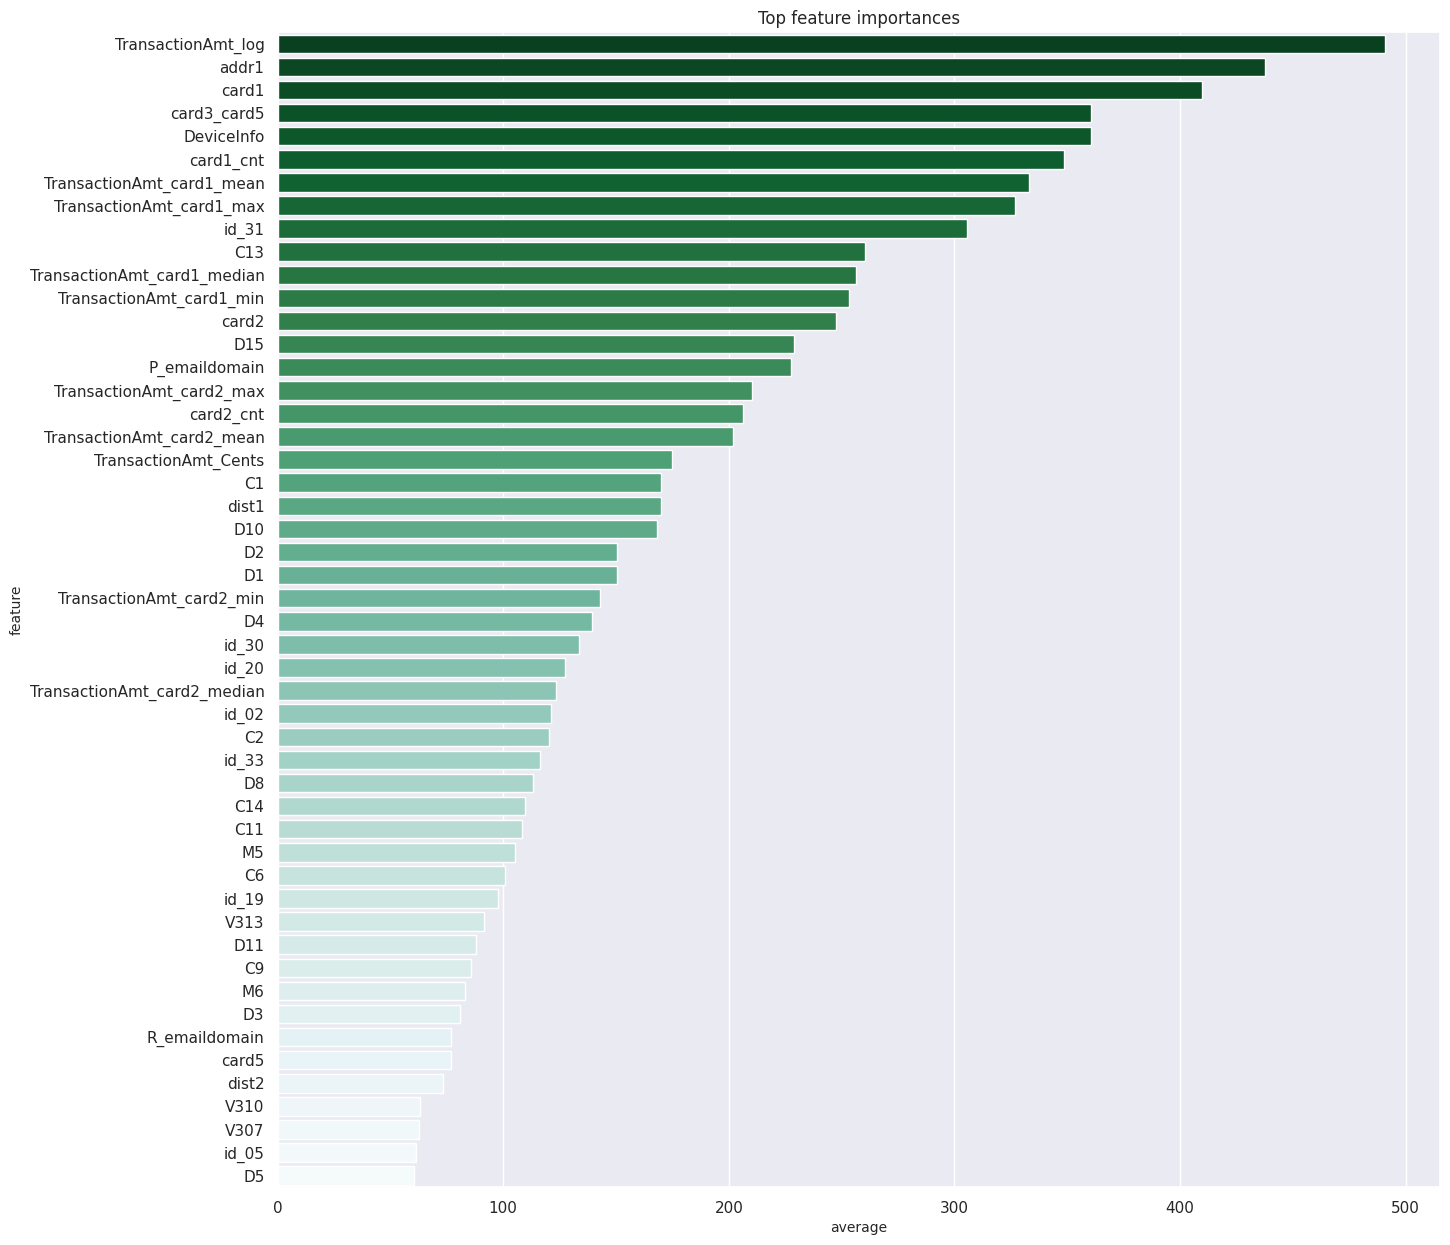

In [67]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

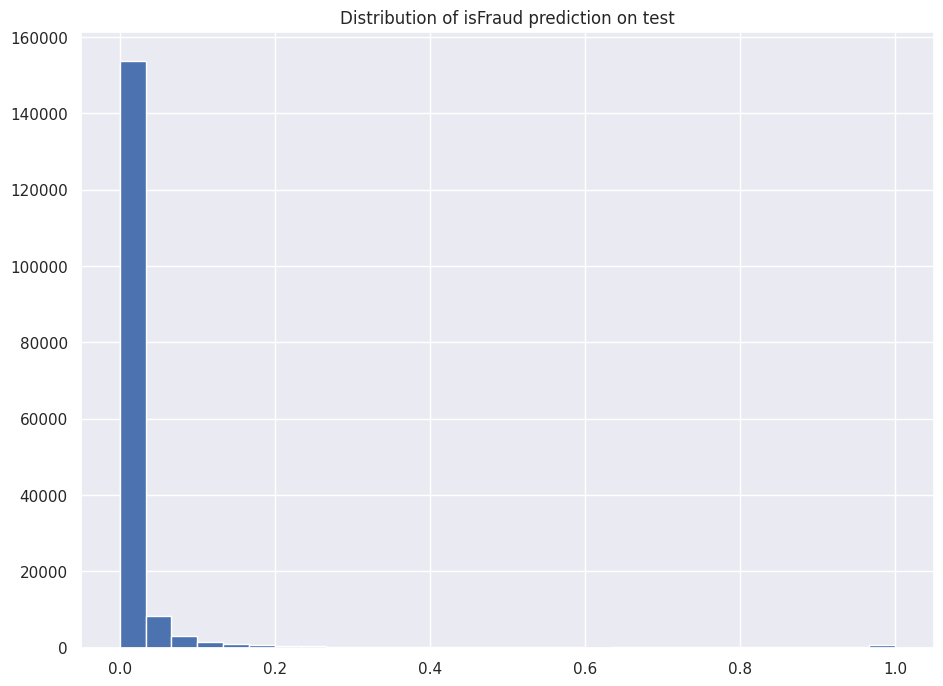

In [68]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

In [69]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_lightgbm_features.csv', index=False) #увидела прирост на лидерборде

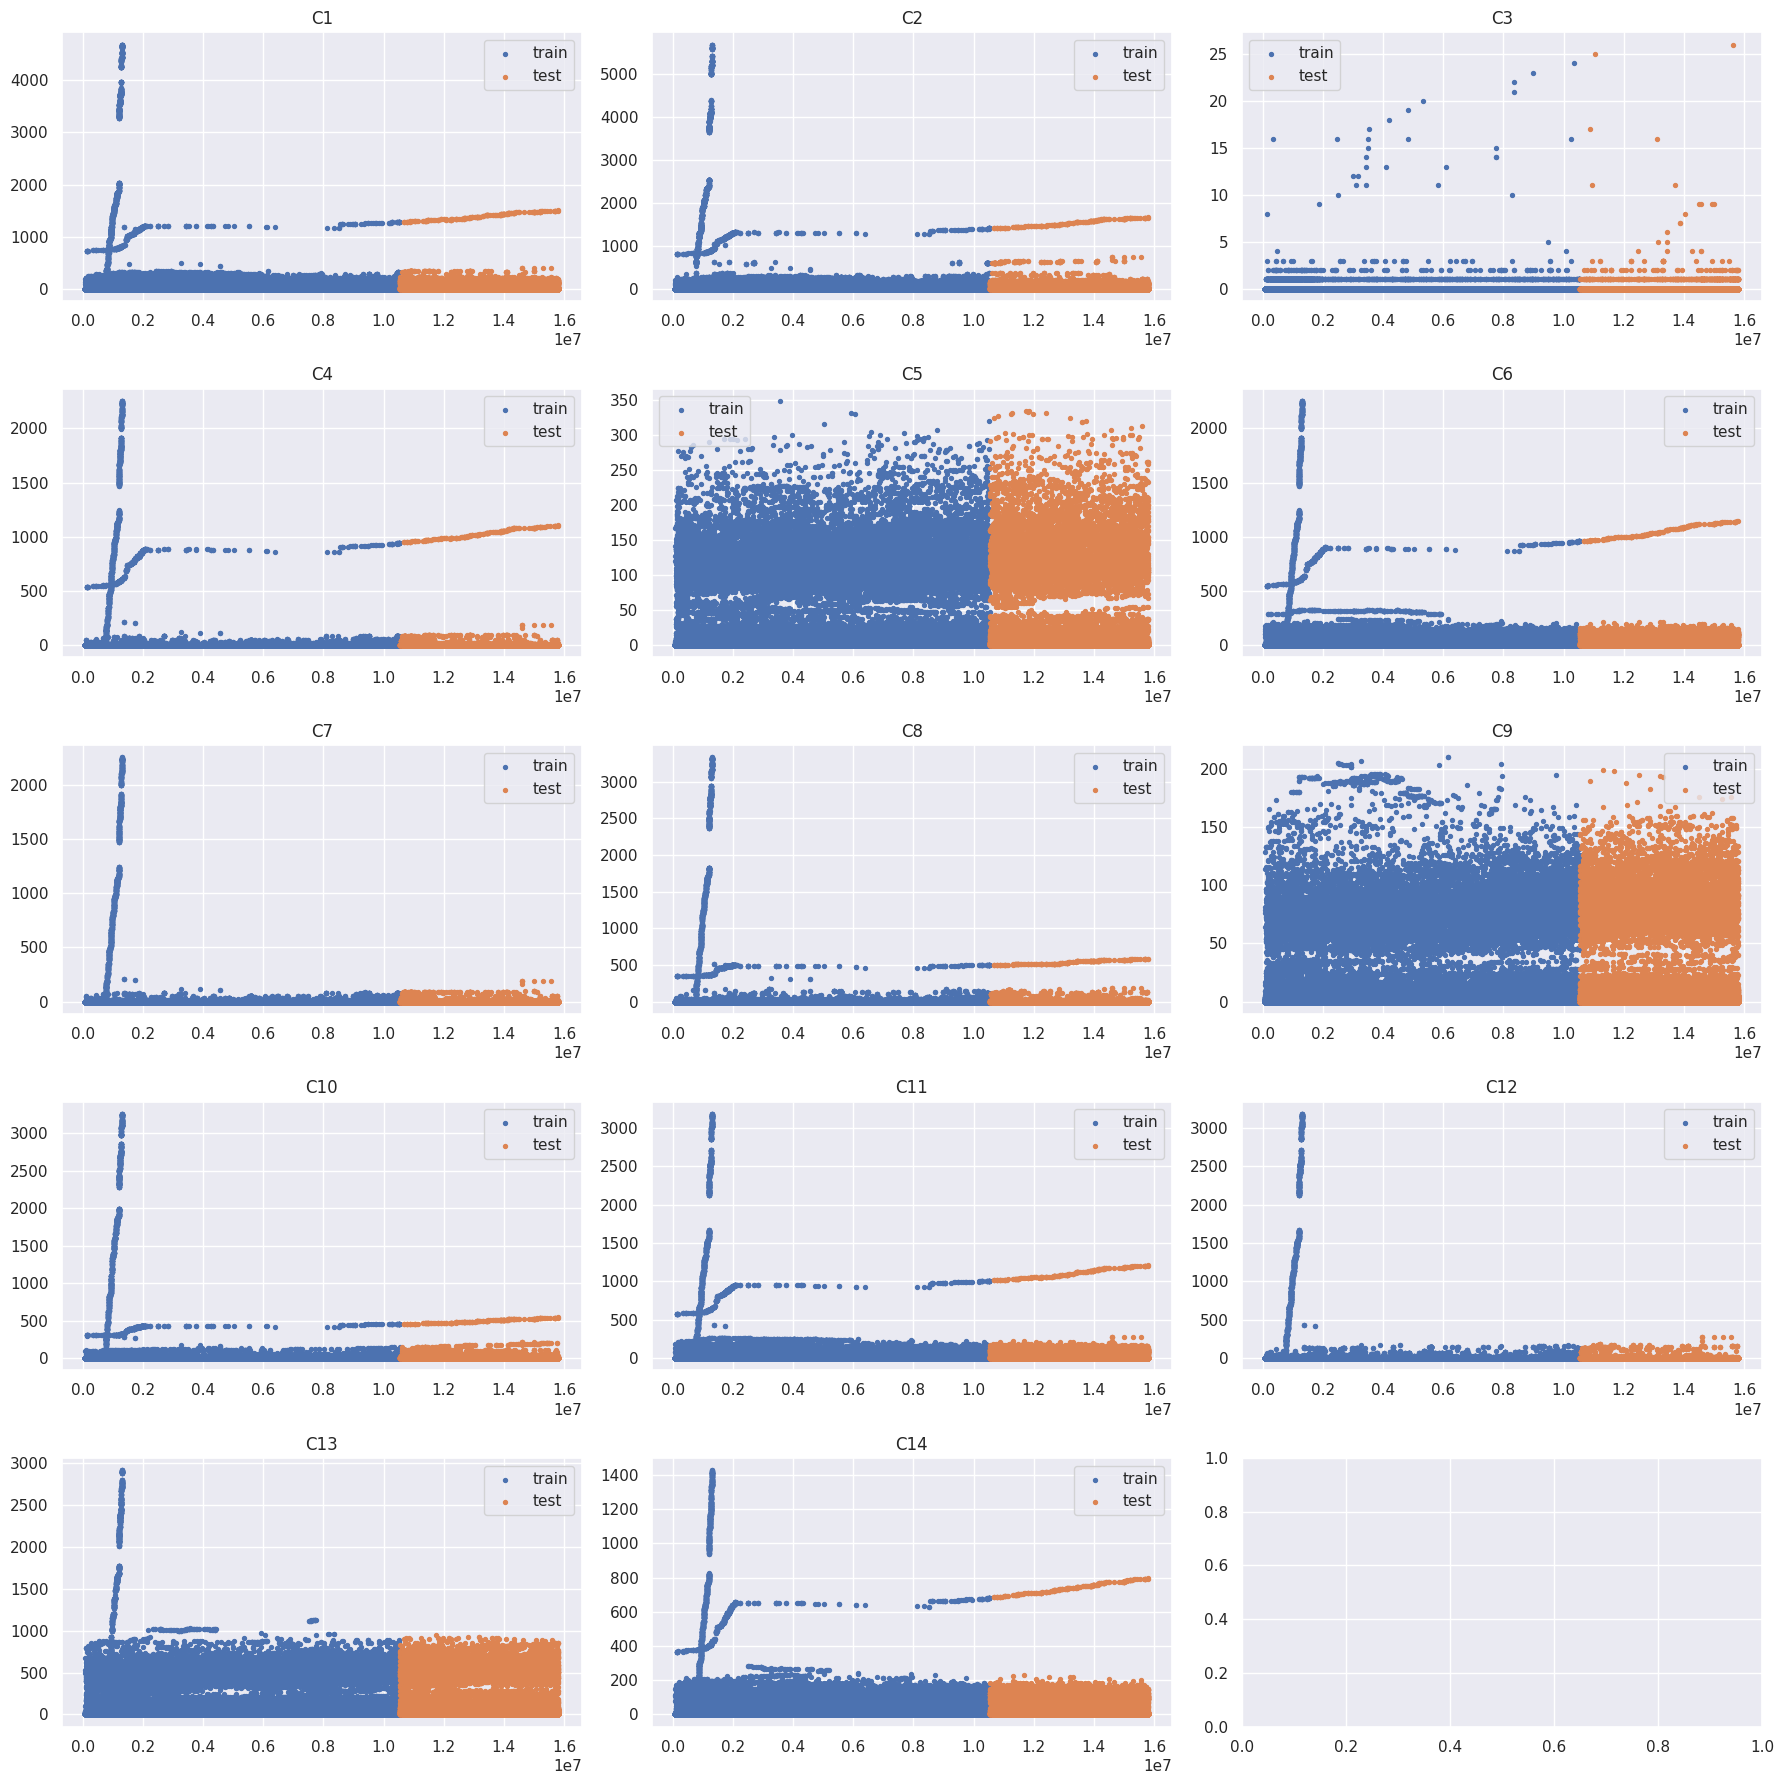

CPU times: user 1min 14s, sys: 2.47 s, total: 1min 16s
Wall time: 1min 18s


In [ ]:
%%time

c_features = [col for col in df_train.columns if col.startswith('C')]
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
for i in range(len(c_features)):
    col = c_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

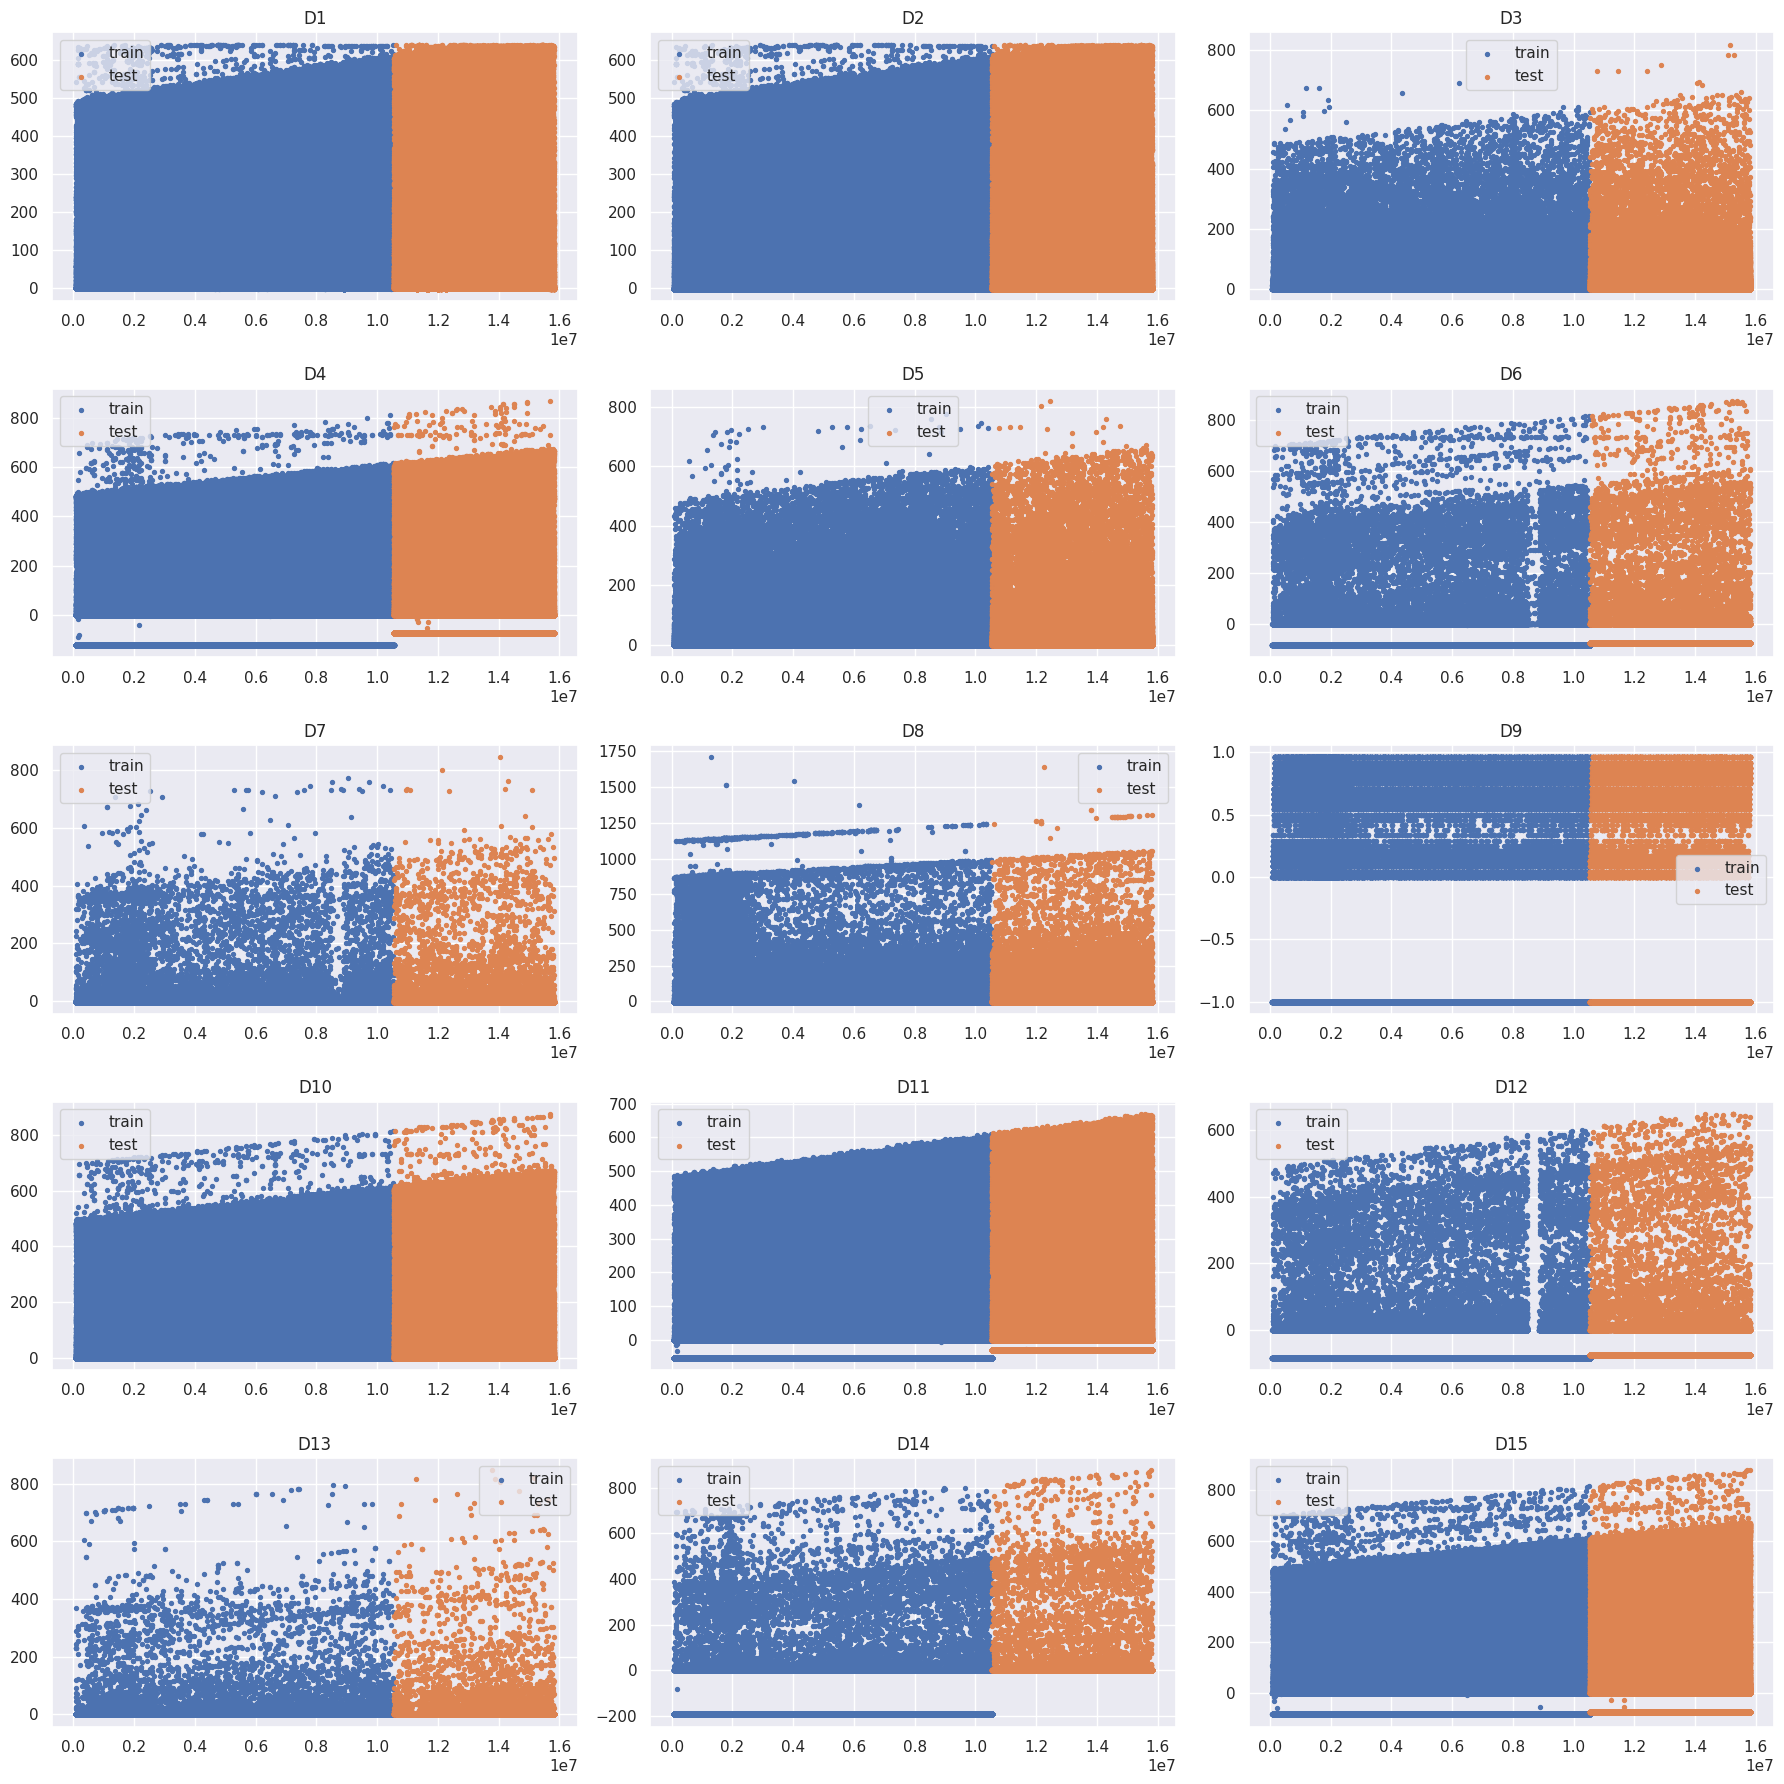

CPU times: user 3min 30s, sys: 652 ms, total: 3min 30s
Wall time: 3min 34s


In [ ]:
%%time

d_features = [col for col in df_train.columns if col.startswith('D')][:-2]
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
for i in range(len(d_features)):
    col = d_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

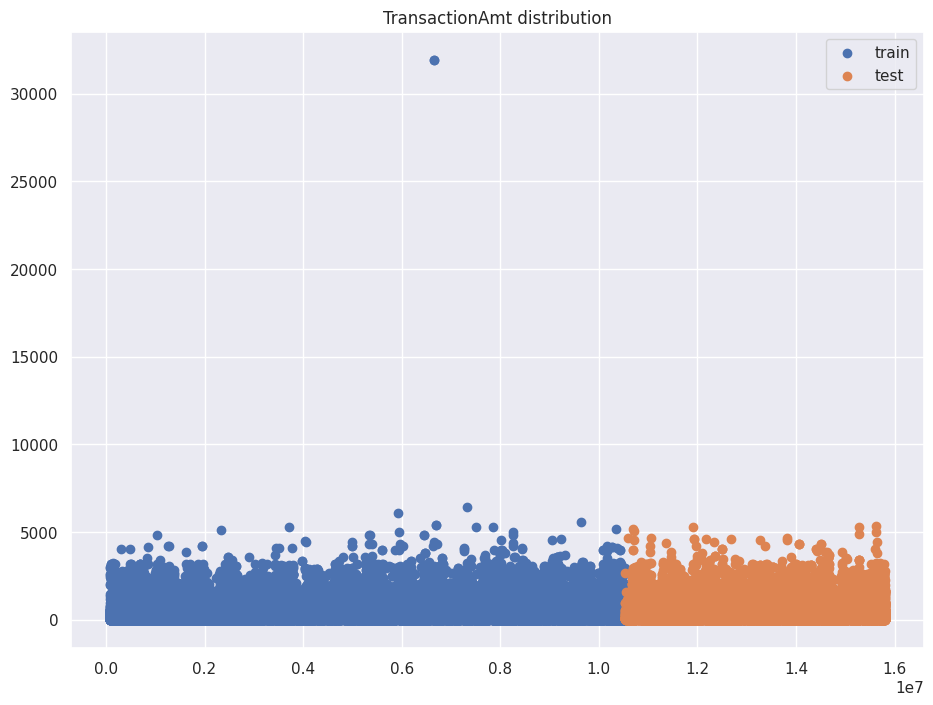

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('TransactionAmt distribution')
plt.scatter(df_train['TransactionDT'], df_train['TransactionAmt'], label='train')
plt.scatter(df_test['TransactionDT'], df_test['TransactionAmt'], label='test')
plt.legend(loc='best')
plt.show()

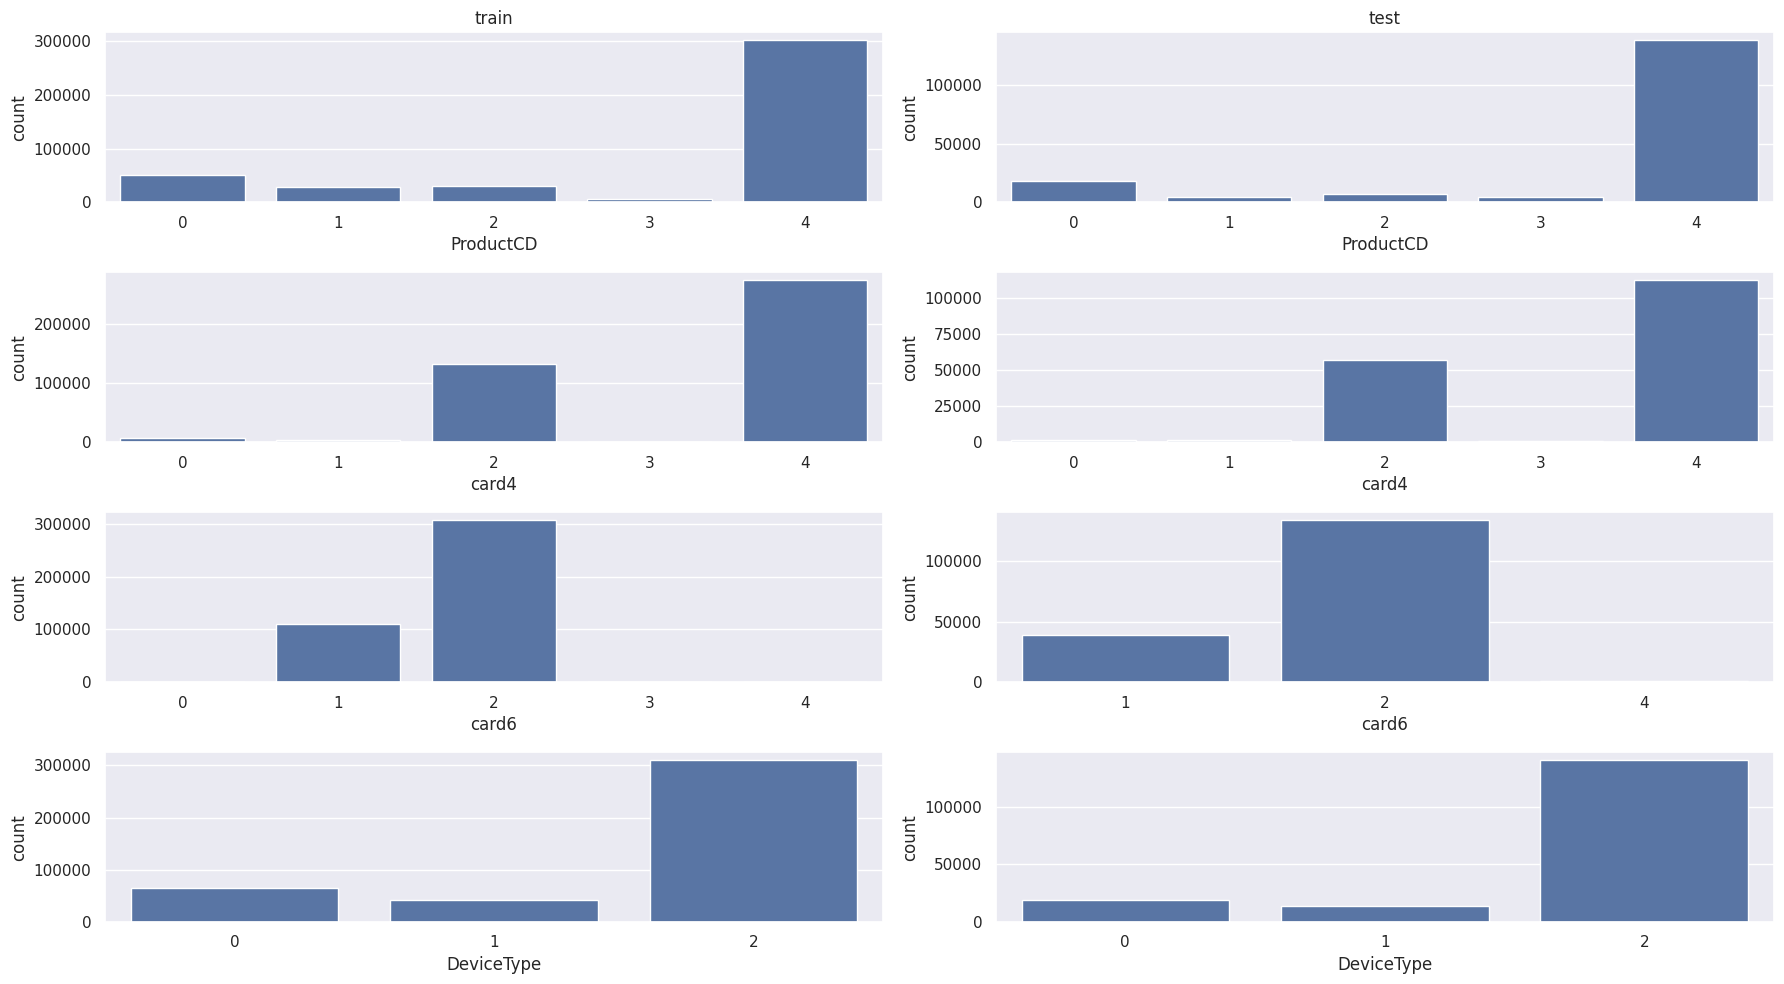

CPU times: user 3.37 s, sys: 199 ms, total: 3.57 s
Wall time: 3.4 s


In [ ]:
%%time

cat_fts = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, ax = plt.subplots(nrows=len(cat_fts), ncols=2, figsize=(18, 10))
ax[0, 0].set_title('train')
ax[0, 1].set_title('test')
for i in range(len(cat_fts)):
    col = cat_fts[i]
    sns.countplot(x=col, ax=ax[i, 0], data=df_train)
    sns.countplot(x=col, ax=ax[i, 1], data=df_test)
plt.tight_layout()
plt.show()

Посмотрим на то, как некоторые признаки связаны с целевой переменной. Это может помочь при генерации новых признаков.

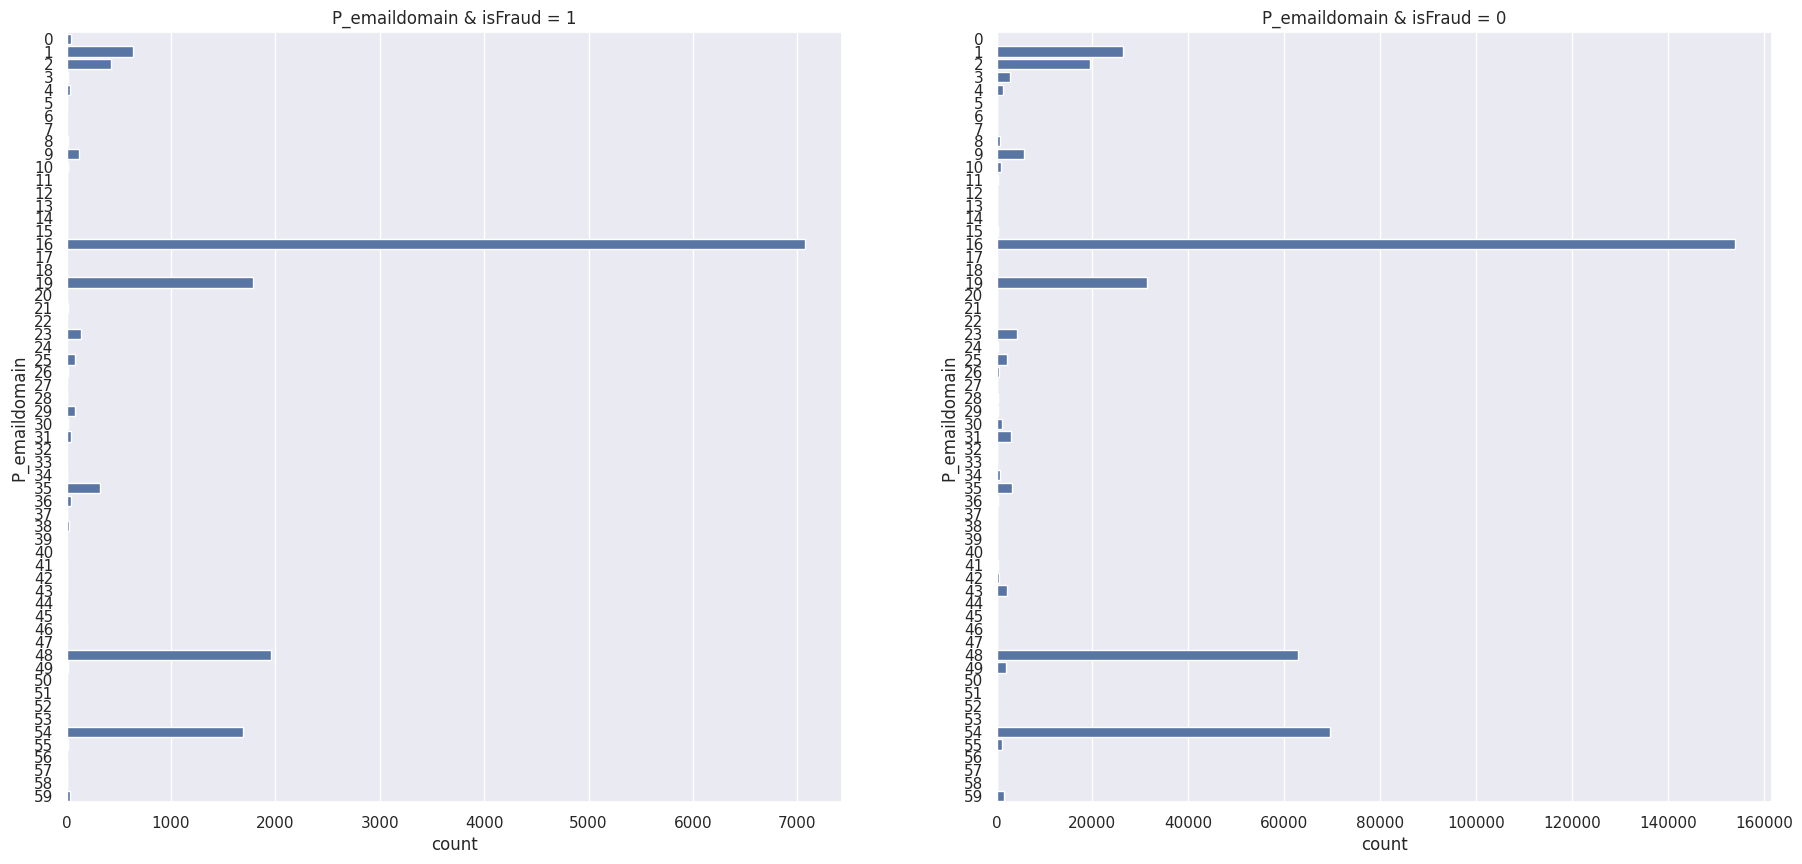

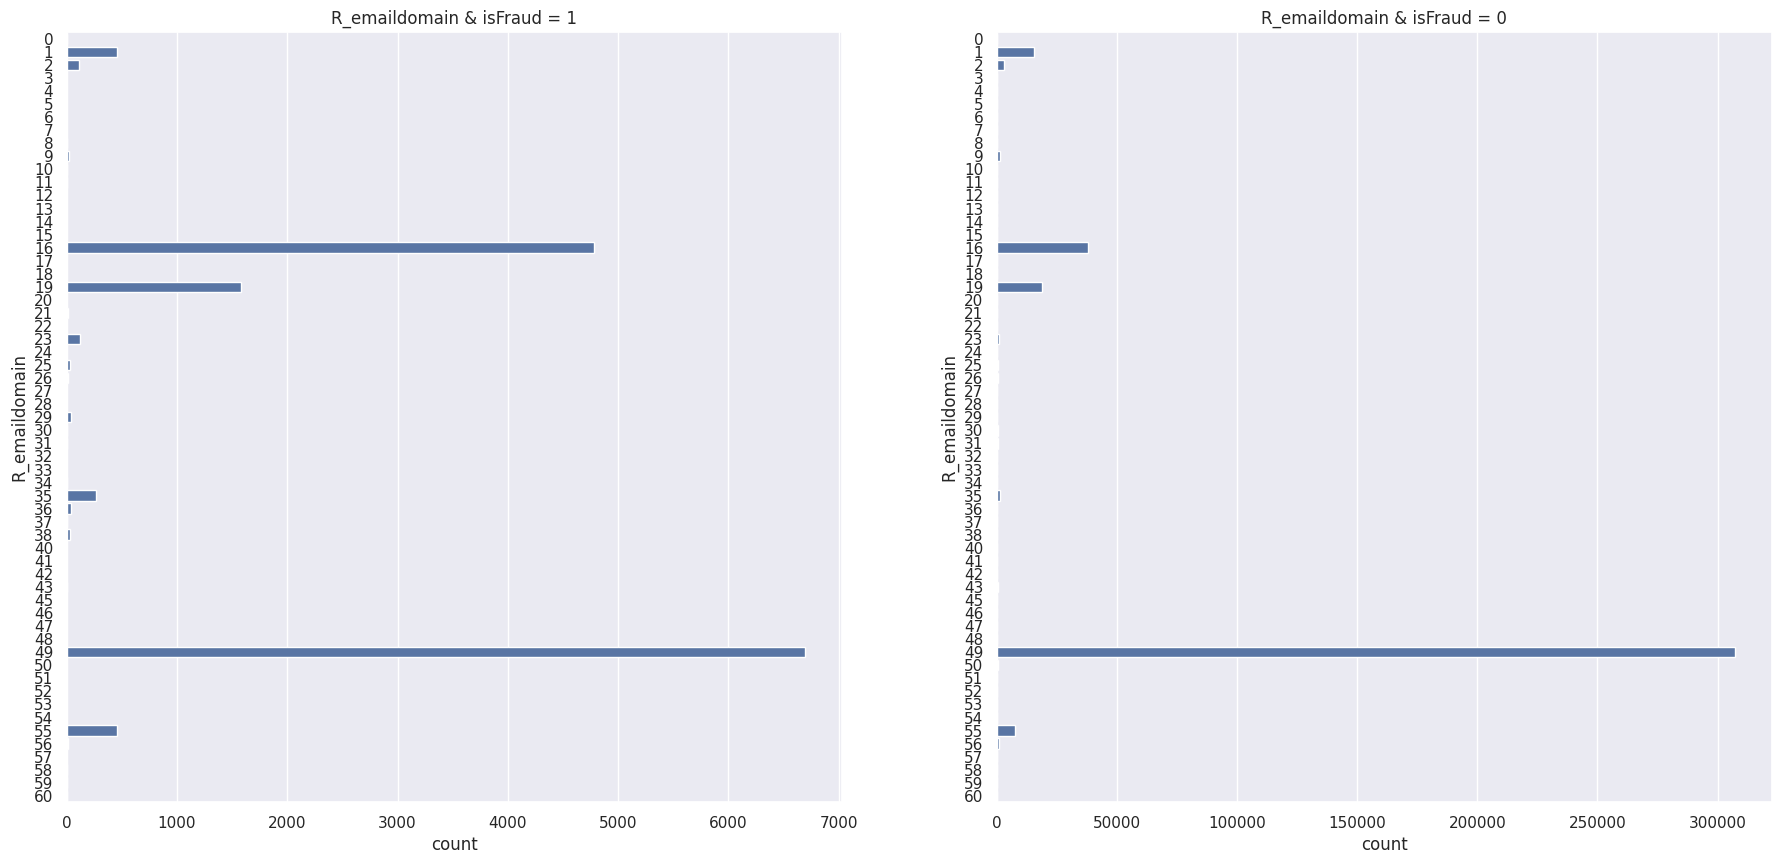

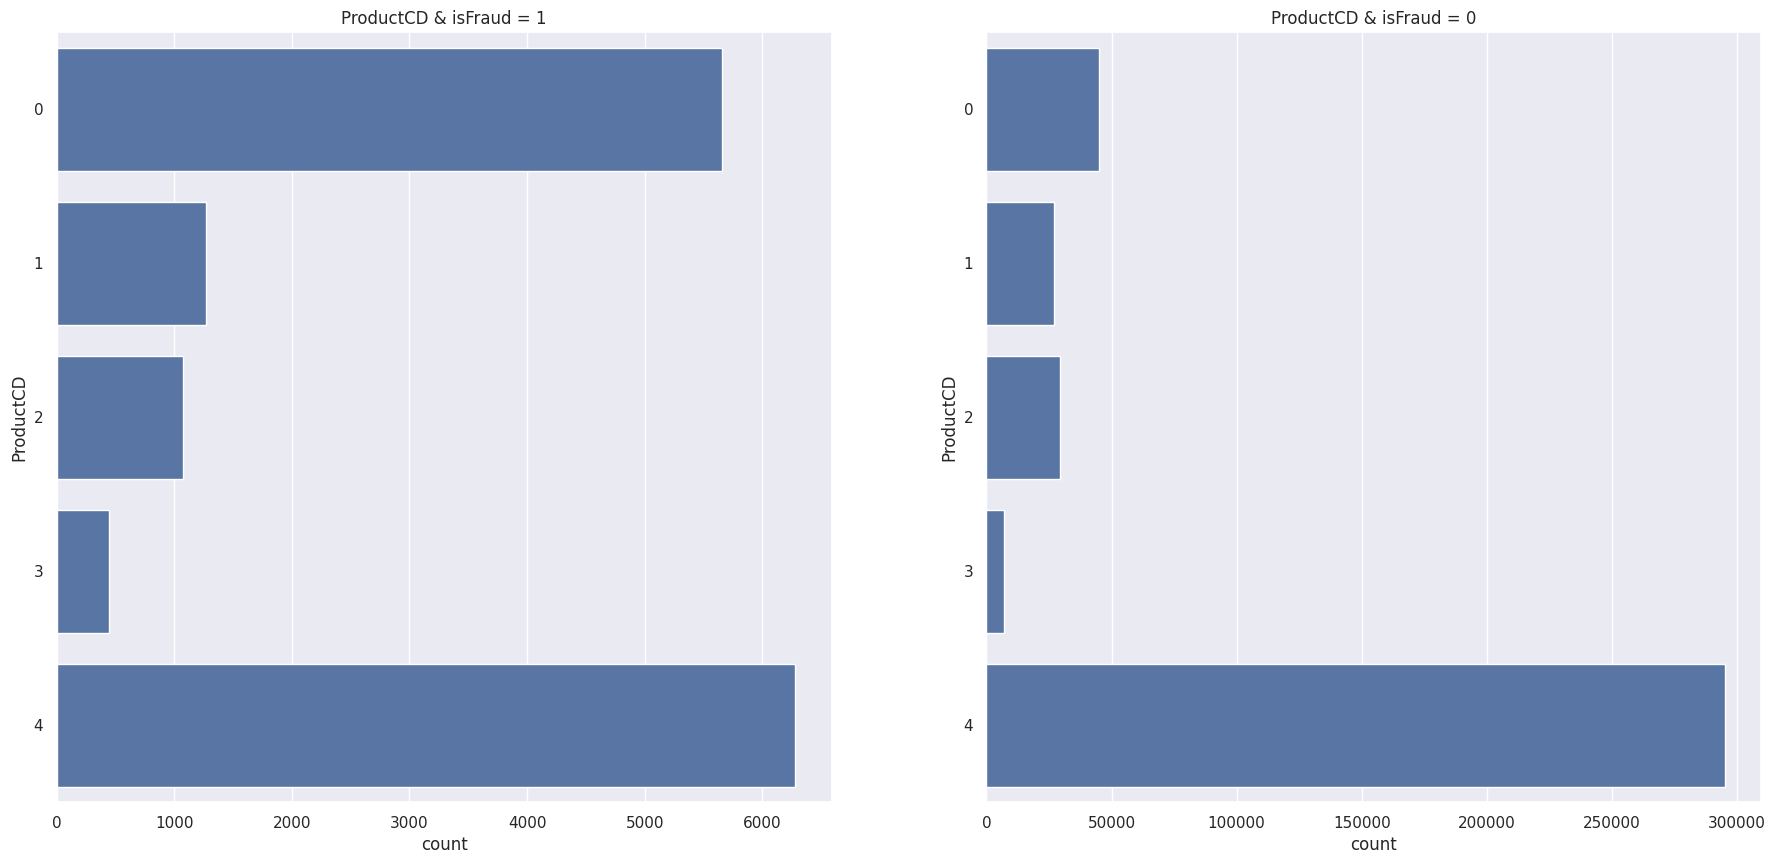

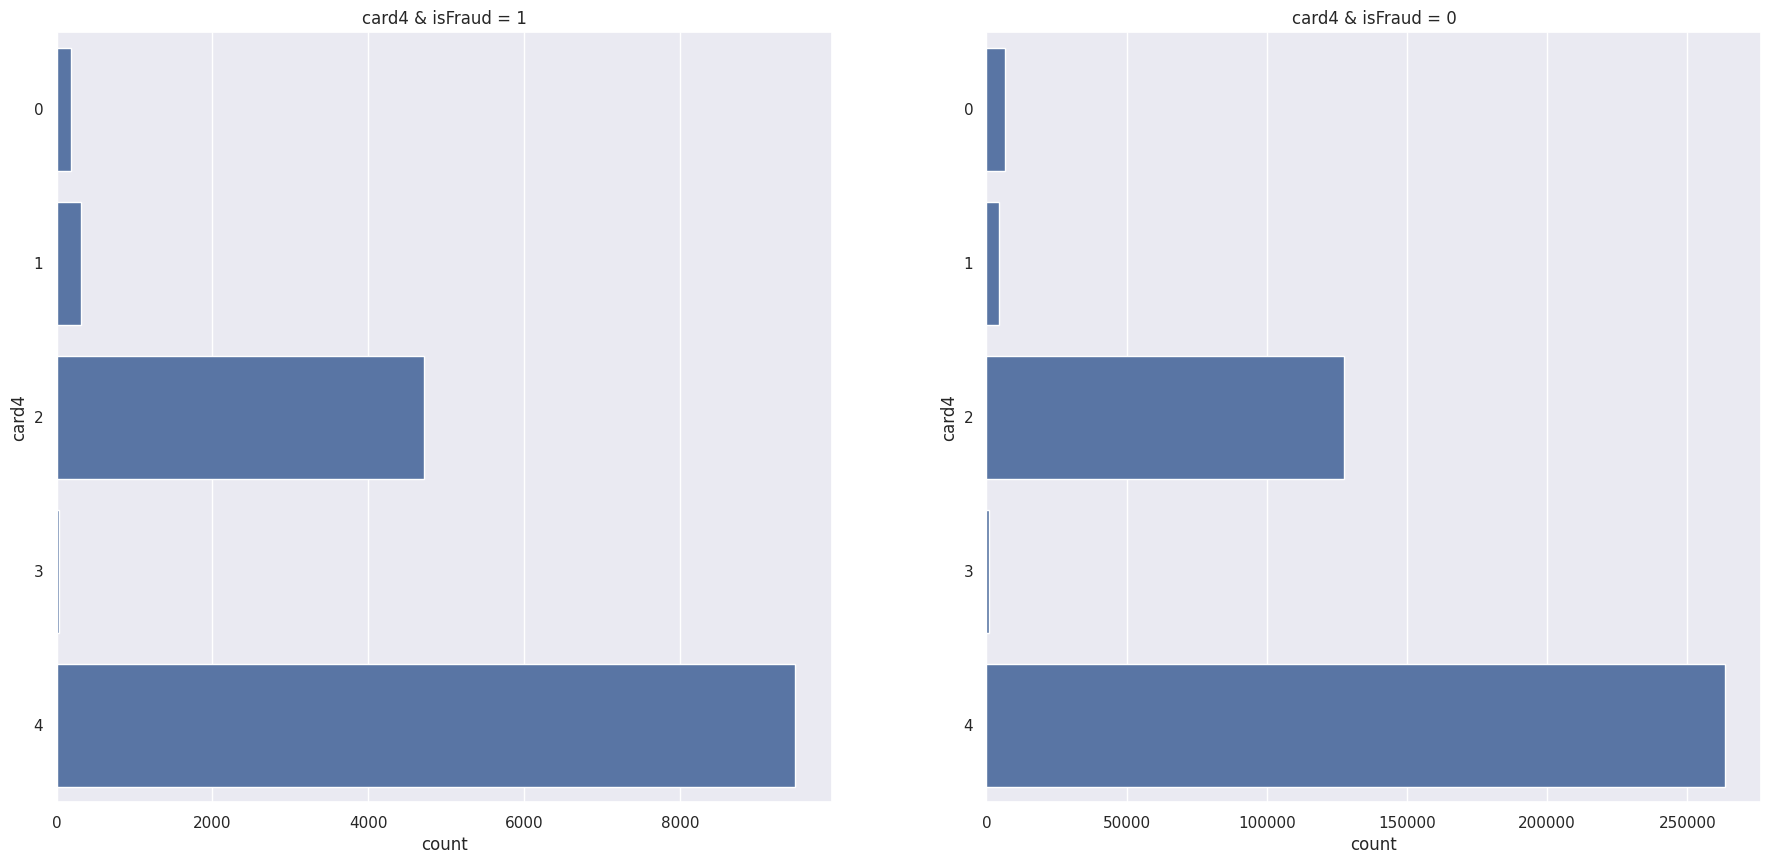

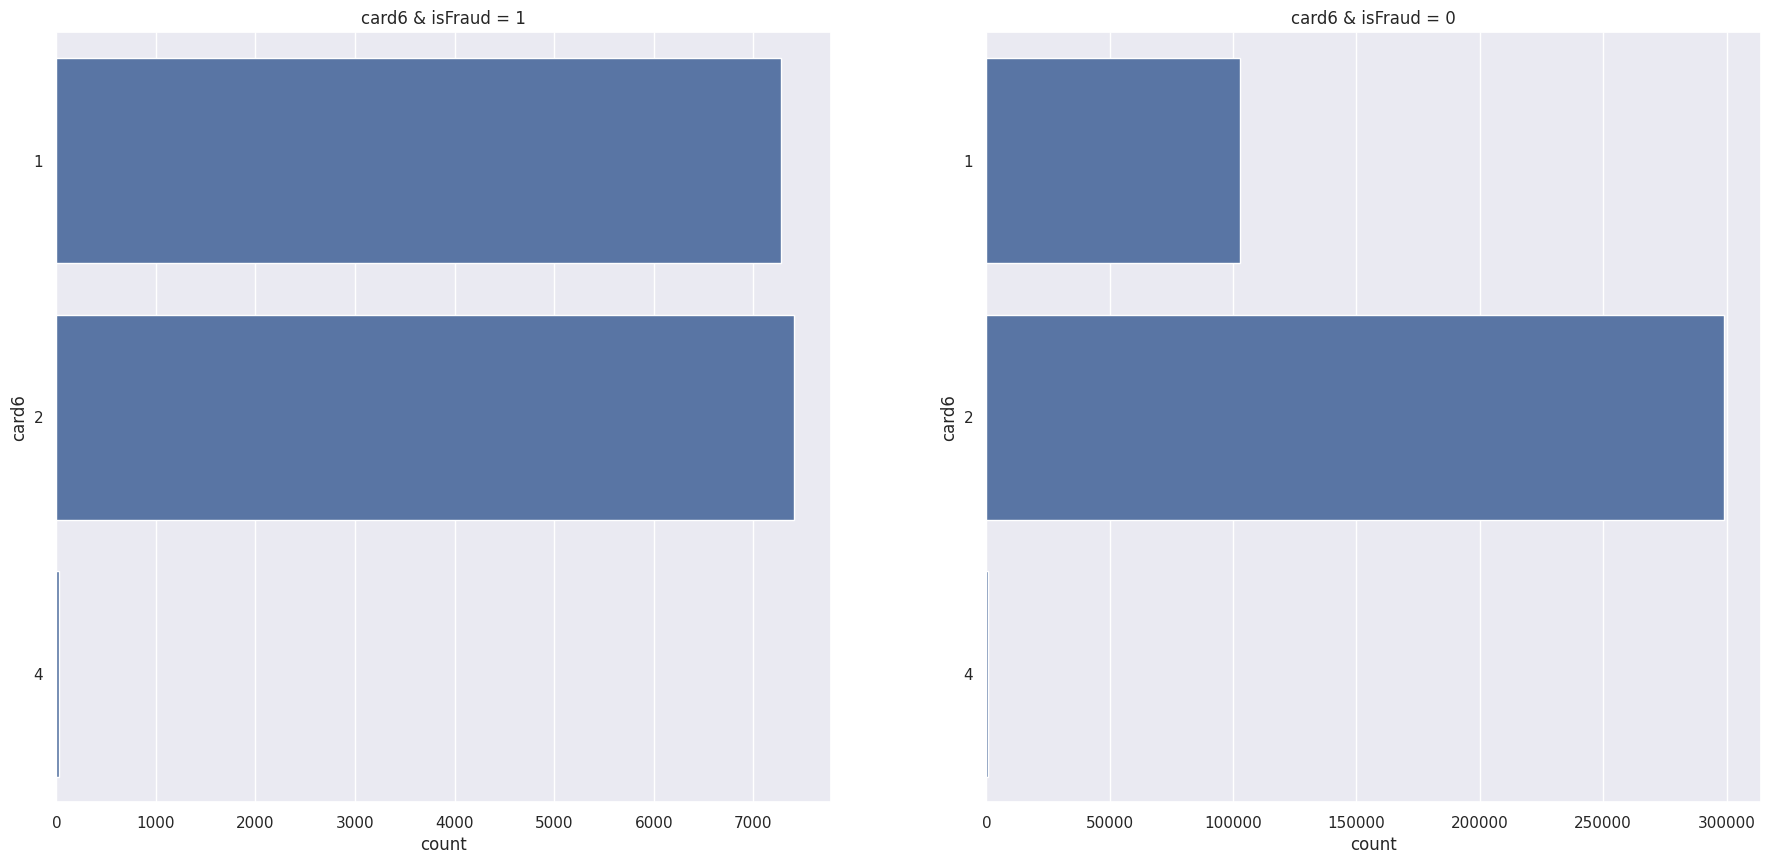

CPU times: user 10.3 s, sys: 1.16 s, total: 11.5 s
Wall time: 11.7 s


In [ ]:
%%time

cols_target = ['P_emaildomain', 'R_emaildomain', 'ProductCD', 'card4', 'card6']

for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    unique_values = [x for x in list(set(df_train[col].values).intersection(set(df_test[col].values))) if str(x) != 'nan']
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['isFraud'] == 1], order=unique_values)
    ax[0].set_title(col + ' & isFraud = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['isFraud'] == 0], order=unique_values)
    ax[1].set_title(col + ' & isFraud = 0')
    plt.show()

Наши данные за 4 месяца

In [ ]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

120.99996527777778

In [ ]:
month_length = 3600 * 24 * 30
df_train['TransactionDT'].shape

(417559,)

In [ ]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [ ]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval)

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.195962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31597
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[466]	valid_0's auc: 0.904218


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.510597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34455
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[657]	valid_0's auc: 0.924913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.479436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34355
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.925934


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.660168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34429
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[495]	valid_0's auc: 0.903993
Fold 0, AUC-ROC: 0.90422
Fold 1, AUC-ROC: 0.92491
Fold 2, AUC-ROC: 0.92593
Fold 

In [ ]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,TransactionAmt,700,1030,288,739
1,ProductCD,28,40,33,47
2,card1,857,1293,383,964
3,card2,675,934,296,749
4,card3,101,121,69,86


In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,TransactionAmt,700,1030,288,739,689.25
1,ProductCD,28,40,33,47,37.00
2,card1,857,1293,383,964,874.25
3,card2,675,934,296,749,663.50
4,card3,101,121,69,86,94.25


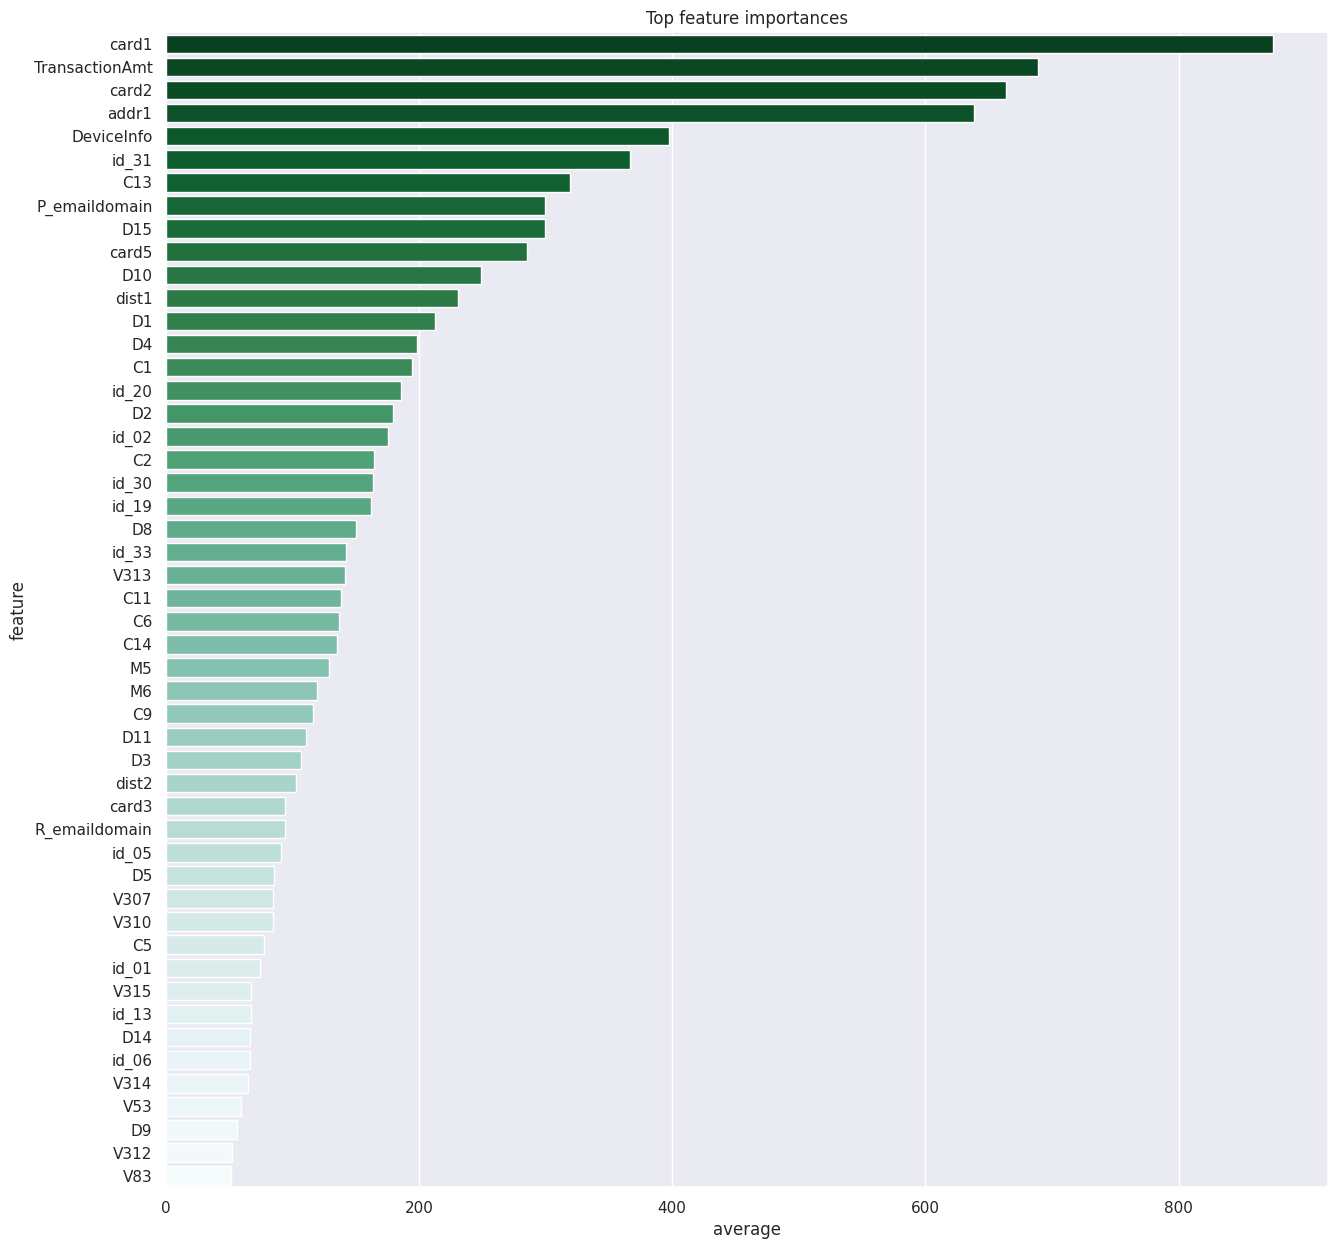

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

In [ ]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.00123481, 0.04591811, 0.01858691, ..., 0.0019171 , 0.01759305,
       0.00423222])

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.001235
1,3404560,0.045918
2,3404561,0.018587
3,3404562,0.007542
4,3404563,0.379665


In [ ]:
sub.to_csv('submission_baseline_lightgbm.csv', index=False)

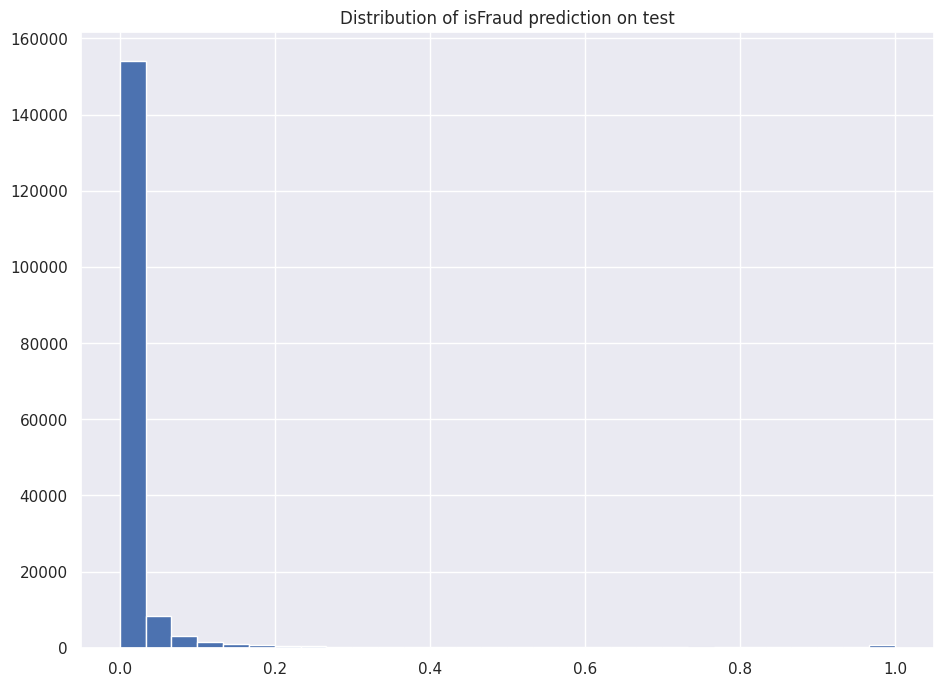

In [ ]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

In [25]:
%%time

from catboost import CatBoostClassifier, Pool

params = {
    'eval_metric': 'AUC',
    'iterations': 3500,
    'random_seed': 13,
    'od_wait': 200,
    'task_type': 'GPU'
}

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    cat_features = df_train.select_dtypes(include=['category']).columns.tolist()

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=200)

    feature_importances['fold_{}'.format(len(scores))] = model.get_feature_importance()

    y_pred = model.predict_proba(X_val)[:, 1]
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)

    y_test_pred = model.predict_proba(df_test)[:, 1]
    test_preds.append(y_test_pred)

for i, score in enumerate(scores):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, score))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

Learning rate set to 0.026233


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6261492	best: 0.6261492 (0)	total: 139ms	remaining: 8m 5s
200:	test: 0.8401044	best: 0.8401044 (200)	total: 23.1s	remaining: 6m 19s
400:	test: 0.8619163	best: 0.8619163 (400)	total: 48.3s	remaining: 6m 13s
600:	test: 0.8719673	best: 0.8719949 (595)	total: 1m 9s	remaining: 5m 34s
800:	test: 0.8784539	best: 0.8784788 (798)	total: 1m 32s	remaining: 5m 12s
1000:	test: 0.8825261	best: 0.8825454 (998)	total: 1m 54s	remaining: 4m 45s
1200:	test: 0.8849224	best: 0.8849224 (1200)	total: 2m 14s	remaining: 4m 17s
1400:	test: 0.8878622	best: 0.8878622 (1400)	total: 2m 36s	remaining: 3m 54s
1600:	test: 0.8899573	best: 0.8899573 (1600)	total: 2m 58s	remaining: 3m 31s
1800:	test: 0.8918447	best: 0.8918447 (1800)	total: 3m 19s	remaining: 3m 8s
2000:	test: 0.8933891	best: 0.8934454 (1993)	total: 3m 41s	remaining: 2m 45s
2200:	test: 0.8949000	best: 0.8949328 (2196)	total: 4m 3s	remaining: 2m 23s
2400:	test: 0.8962339	best: 0.8962374 (2399)	total: 4m 23s	remaining: 2m
2600:	test: 0.8970830	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6863516	best: 0.6863516 (0)	total: 134ms	remaining: 7m 49s
200:	test: 0.8777828	best: 0.8777828 (200)	total: 24.7s	remaining: 6m 44s
400:	test: 0.8877676	best: 0.8877759 (398)	total: 48.9s	remaining: 6m 18s
600:	test: 0.8933445	best: 0.8933445 (600)	total: 1m 12s	remaining: 5m 50s
800:	test: 0.8969488	best: 0.8969543 (799)	total: 1m 36s	remaining: 5m 23s
1000:	test: 0.8992870	best: 0.8992870 (1000)	total: 2m	remaining: 5m
1200:	test: 0.9009702	best: 0.9009702 (1200)	total: 2m 24s	remaining: 4m 36s
1400:	test: 0.9023229	best: 0.9023229 (1400)	total: 2m 49s	remaining: 4m 13s
1600:	test: 0.9036531	best: 0.9036545 (1599)	total: 3m 13s	remaining: 3m 49s
1800:	test: 0.9048403	best: 0.9048403 (1800)	total: 3m 37s	remaining: 3m 25s
2000:	test: 0.9059407	best: 0.9059407 (2000)	total: 4m 1s	remaining: 3m
2200:	test: 0.9069461	best: 0.9069461 (2200)	total: 4m 25s	remaining: 2m 36s
2400:	test: 0.9077864	best: 0.9077864 (2400)	total: 4m 49s	remaining: 2m 12s
2600:	test: 0.9083539	best: 0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6873403	best: 0.6873403 (0)	total: 134ms	remaining: 7m 47s
200:	test: 0.8877377	best: 0.8877377 (200)	total: 24.5s	remaining: 6m 42s
400:	test: 0.8968727	best: 0.8968821 (398)	total: 48.8s	remaining: 6m 17s
600:	test: 0.9009054	best: 0.9009054 (600)	total: 1m 12s	remaining: 5m 51s
800:	test: 0.9031484	best: 0.9031615 (799)	total: 1m 36s	remaining: 5m 26s
1000:	test: 0.9047447	best: 0.9047447 (1000)	total: 1m 59s	remaining: 4m 59s
1200:	test: 0.9058174	best: 0.9058174 (1200)	total: 2m 24s	remaining: 4m 35s
1400:	test: 0.9069296	best: 0.9069296 (1400)	total: 2m 47s	remaining: 4m 11s
1600:	test: 0.9074667	best: 0.9074683 (1597)	total: 3m 12s	remaining: 3m 47s
1800:	test: 0.9079980	best: 0.9080946 (1778)	total: 3m 35s	remaining: 3m 23s
2000:	test: 0.9088615	best: 0.9088748 (1996)	total: 3m 59s	remaining: 2m 59s
2200:	test: 0.9091964	best: 0.9091964 (2200)	total: 4m 23s	remaining: 2m 35s
2400:	test: 0.9097172	best: 0.9097227 (2399)	total: 4m 46s	remaining: 2m 11s
2600:	test: 0.91

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6900370	best: 0.6900370 (0)	total: 131ms	remaining: 7m 36s
200:	test: 0.8707157	best: 0.8707157 (200)	total: 23.7s	remaining: 6m 28s
400:	test: 0.8807819	best: 0.8807819 (400)	total: 46.7s	remaining: 6m 1s
600:	test: 0.8851768	best: 0.8851768 (600)	total: 1m 8s	remaining: 5m 32s
800:	test: 0.8884695	best: 0.8884695 (800)	total: 1m 32s	remaining: 5m 10s
1000:	test: 0.8906775	best: 0.8906775 (1000)	total: 1m 55s	remaining: 4m 48s
1200:	test: 0.8921911	best: 0.8922175 (1183)	total: 2m 19s	remaining: 4m 26s
1400:	test: 0.8935426	best: 0.8935426 (1400)	total: 2m 41s	remaining: 4m 2s
1600:	test: 0.8946253	best: 0.8947010 (1580)	total: 3m 4s	remaining: 3m 39s
1800:	test: 0.8959367	best: 0.8960064 (1790)	total: 3m 28s	remaining: 3m 16s
2000:	test: 0.8970198	best: 0.8970266 (1997)	total: 3m 51s	remaining: 2m 53s
2200:	test: 0.8976708	best: 0.8977032 (2182)	total: 4m 15s	remaining: 2m 30s
2400:	test: 0.8984522	best: 0.8984571 (2396)	total: 4m 39s	remaining: 2m 7s
2600:	test: 0.8990255

In [26]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.00840126, 0.07794926, 0.02099778, ..., 0.00477106, 0.04163666,
       0.01719377])

In [27]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.008401
1,3404560,0.077949
2,3404561,0.020998
3,3404562,0.017623
4,3404563,0.293039


In [28]:
sub.to_csv('submission_catboost_features.csv', index=False)

catboost CV AUC-ROC: 0.90682 лидерборд 0.90184

lightfm CV AUC-ROC: 0.91661 лидерборд 0.91767

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваша работа с аномалиями здесь

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста